# Tutorial on using the CMBFields objects

You should go through an evaluate everything, including these first two cells:

In [1]:
push!(LOAD_PATH, pwd()*"/../src")
using BayesLensSPTpol
using CMBFields
using PyPlot
using PyCall


#can comment this out if you don't care about adjusting plot looks:
@pyimport seaborn as sns
sns.set_context("notebook",font_scale=1.4,rc=Dict("lines.markeredgewidth"=>1))
sns.set_palette("colorblind")
# sns.set_style("darkgrid")
sns.set_style("ticks",Dict("xtick.direction"=>"in","ytick.direction"=>"in","image.cmap"=>"jet"))

In [2]:
# --- set grid geometry and cls
dm     = 2
nside  = nextprod([2,3,5,7], 256)
period = nside*pi/(180*60)   # nside*pi/(180*60) = 1 arcmin pixels
Ωpix   = deg2rad(1/60)^2
g      = FFTgrid(dm, period, nside)

# --- noise and signal cls
const r   = 0.1    # this will be the simulation truth r value used to generate the data
const r0  = 1.0    # baseline r0 value used to rescale B mode in the algorithm
cls = class(r = r, r0 = r0);

The `CMBFields` package gives you a bunch of objects with which you can manipulate CMB fields (T, E, $\phi$, etc...) and operators acting on those fields. Currently just a flat sky spin-0 field (i.e. T or $\phi$) is implemented, but the idea is to extend this to spin-2 fields (E/B), and eventually even curved sky pixelization, and it'll all work transparently behind the scenes. 

For spin-0 flat sky, we have two objects, one which stores a map, and another which stores the Fourier transform of a map:

In [3]:
n = FlatS0Map(randn(nside,nside),g)
s = FlatS0Fourier(complex(randn(nside,nside)),g);

One of the basic functionalities provided is that you can do operations on these objects and any conversions between Map/Fourier space are done automatically. For example, if you add them, they are automatically converted to a common basis.

(Note:map+fourier always gives a map by default)

In [4]:
@show typeof(n+n)
@show typeof(n+s)
@show typeof(s+s);

typeof(n + n) = CMBFields.FlatS0Map{Float64}
typeof(n + s) = CMBFields.FlatS0Map{Float64}
typeof(s + s) = CMBFields.FlatS0Fourier{Float64}


You can also do arithmetic on them,

In [5]:
y = 2*n + s/5 + 1;

To get the underlying data (e.g. to plot it), use `[:Tx]` to get the map or `[:Tl]` to get the Fourier transform. If you do `[:Tx]` on a Fourier object or `[:Tl]` on a Map object, again the transform is done automatically. 

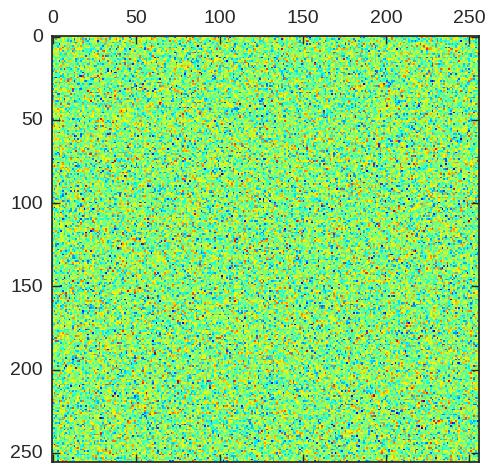

PyObject <matplotlib.image.AxesImage object at 0x7f43788e64e0>

In [6]:
s[:Tx] |> matshow

We also have object which represent linear operations on these fields. The covariance of a field is one such linear operator, and we can construct  objects which are a covariance which is diagonal in a particular basis. For example, and signal covariance which is diagonal in Fourier space and the noise covariance which is diagonal in Map space. 

In [17]:
S = Cℓ_to_cov(FlatS0FourierDiagCov, cls[:ell], cls[:tt], g);
S.Cl[S.Cl.==0] = 1e-8 #threshold S so we can safely do S^-1

# add a "mask" by blowing up the noise in the center of the map
μKarcminT = 5
N = FlatS0MapDiagCov(fill(μKarcminT^2 * Ωpix,(nside,nside)),g);
mi,me = (round(Int,(0.5+x*0.25)*nside) for x=[-1,1])
N.Cx[mi:me,mi:me] *= 1000000;

We can then draw realizations of fields from these covariances:

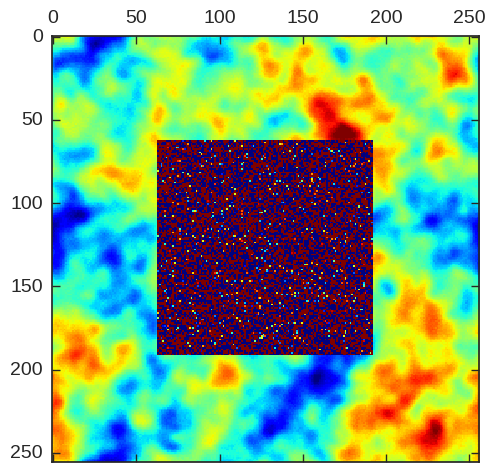

PyObject <matplotlib.image.AxesImage object at 0x7f43788027b8>

In [8]:
s = simulate(S)
n = simulate(N) / √Ωpix # <-- TODO: fix needing this factor
d = s + n;

matshow(d[:Tx], vmin=-300, vmax=300)

Similarly, we can operate on them with the covariances, and if needed, they are converted into the basis in which the covariance in diagonal so as to perform the operation:

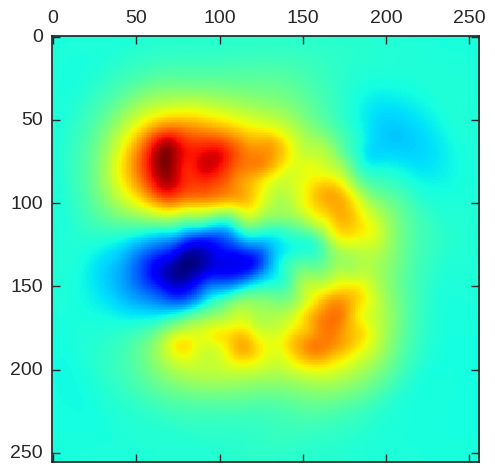

PyObject <matplotlib.image.AxesImage object at 0x7f43787edf98>

In [9]:
(S*n)[:Tx] |> matshow

The covariances can be be combined into arbitrary expression which can then be applied to fields:

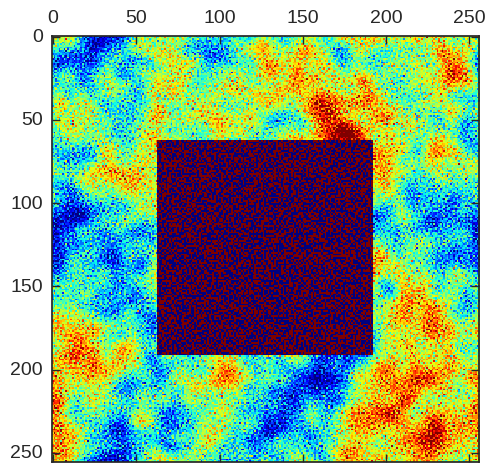

PyObject <matplotlib.image.AxesImage object at 0x7f433c0b2b70>

In [10]:
A = 1+N*S^(-1)
matshow((A*s)[:Tx], vmin=-300, vmax=300)

Finally, when we need to feed these things into certain algortihms (like conjugate gradient, etc...), we need normal vectors and things operating on vectors. For this we have three things, 

* `x[:]` gives a field as a vector (depending on if `x` is Map or Fourier basis)
* `A[~x]` takes an operator and returns something which on a vector of the type produced by `x[:]`, i.e. on a Map is x is a Map and vice-versa
* `v[~x]` takes a vector `v` and turns it into a Field object assuming

That is, `A*x` is equivalent to `(A[~x] * x[:])[~x]`.

The `~` in `A[~n]` is supposed to mean A acting on something that looks like `n`, hence `~n`.

In [11]:
s[:]

65536-element Array{Complex{Float64},1}:
           -2.26213e-6+0.0im        
            0.00847617-0.00607712im 
            -0.0109923-0.00272586im 
             5.5799e-5+0.00622473im 
           -0.00142192-0.00516318im 
           -0.00070354+0.0057904im  
           0.000384545+0.00175844im 
          -0.000207468-0.000261917im
          -0.000954798+0.000432548im
            0.00268662-0.00066136im 
            0.00136854+0.00141207im 
          -0.000507603-0.000243263im
           0.000256912+0.00100399im 
                      ⋮             
          -0.000225974+0.000685272im
 -0.000720879-3.99953e-5im          
          -0.000552285-0.00124727im 
            0.00118692-0.00014802im 
           0.000227099-0.00151376im 
           -0.00308514+0.0010385im  
             0.0014824-0.00228162im 
           -0.00133646+0.000409544im
           -0.00249501-0.00219006im 
           -0.00213079-0.003266im   
           -0.00657916-0.00735604im 
            0.00946175-0.0197968im

In [12]:
A[~s] * s[:]

65536-element Array{Complex{Float64},1}:
 -146.131+0.0im     
  81.9961-6.81925im 
  17.9015+3.53659im 
 -29.8277+4.21909im 
 -12.4722-5.05143im 
  11.2099-0.63163im 
  20.4258+4.26275im 
  -13.773-3.81562im 
 -12.9008+2.53767im 
  2.15222+1.4496im  
  22.7956-10.133im  
 -8.85355+15.4292im 
 -18.2054-9.72114im 
         ⋮          
  7.03234-4.22795im 
     9.83+14.3273im 
 -22.0062+0.342852im
  5.93105-13.726im  
  5.67602+0.197147im
  8.31202+18.0144im 
 -14.4593-10.7506im 
 -3.59796-7.24182im 
  6.17081+6.08851im 
  18.7262+6.09293im 
 -13.4768-4.17542im 
 -46.2972-5.07922im 

In [13]:
typeof((A[~s] * s[:])[~s])

CMBFields.FlatS0Fourier{Float64}

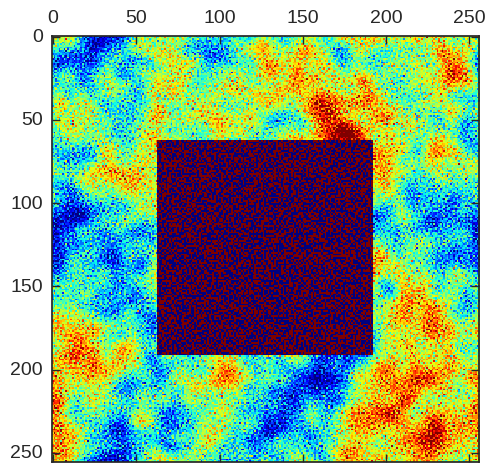

PyObject <matplotlib.image.AxesImage object at 0x7f433c011ac8>

In [14]:
matshow((A[~s] * s[:])[~s][:Tx], vmin=-300, vmax=300)

We can put this together to quickly code up a conjugate gradient solution of the Wiener filter using the `cg` function from `IterativeSolvers`.

In [15]:
using IterativeSolvers

# the form in which we apply the Wiener filter
A = (1+S^(1/2)*N^(-1)*S^(1/2))
b = S^(1/2)*N^(-1)*d

# note the use of the ~ notation
x = cg(A[~b], b[:], tol=1e-3)[~b]
swf = S^(1/2)*x;

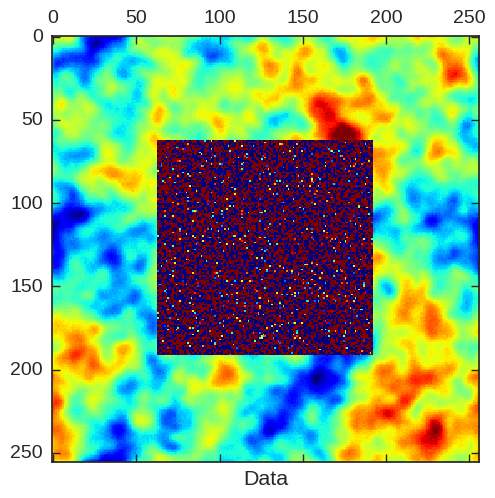

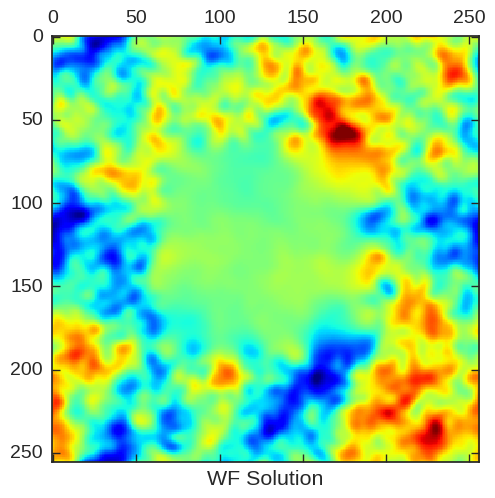

PyObject <matplotlib.text.Text object at 0x7f433469f0f0>

In [16]:
matshow(d[:Tx], vmin=-300, vmax=300); xlabel("Data")
matshow(swf[:Tx], vmin=-300, vmax=300); xlabel("WF Solution")